<a href="https://colab.research.google.com/github/happycindy7201/-/blob/main/%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D(Cifar_10%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B_LeRu)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

모델 복잡도 증가: 첫 번째 Conv2D 레이어에서 필터 수를 10에서 32로 설정
conv_model.add(Conv2D(32, (3, 3), activation='swish', padding='same', input_shape=(32, 32, 3)))

Batch Normalization 추가: 각 Conv2D 레이어 뒤에 Batch Normalization을 추가하여 학습 안정성 향상 시도
conv_model.add(BatchNormalization())

Dropout 적용: 과적합을 방지하기 위해 Dropout을 추가
conv_model.add(Dropout(0.2))  # 예: 첫 번째 Dropout 레이어

데이터 증강도 해봐야 합니다.

학습이 진행됨에 따라 학습률을 줄이기 위해 Learning Rate Scheduler 적용해 보면 좋겠습니다.

검증 데이터셋에서 성능이 향상되지 않으면 학습을 중지해 최적의 모델을 얻도록 Early Stopping 적용을 하면 좋습니다.

##CIFAR-10 데이터셋으로 합성곱 신경망을 개선하기 위한 코드

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

##데이터 준비

In [2]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


##데이터 정규화

In [3]:
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255

##데이터 증강

In [4]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

##One-hot 인코딩

In [5]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

##합성곱 신경망 모델 개선

In [8]:
conv_model = tf.keras.Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
conv_model.add(BatchNormalization())
conv_model.add(MaxPooling2D((2, 2)))
conv_model.add(Dropout(0.2))

conv_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model.add(BatchNormalization())
conv_model.add(MaxPooling2D((2, 2)))
conv_model.add(Dropout(0.3))

conv_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
conv_model.add(BatchNormalization())
conv_model.add(MaxPooling2D((2, 2)))
conv_model.add(Dropout(0.4))

conv_model.add(Flatten())
conv_model.add(Dense(256, activation='relu'))
conv_model.add(Dropout(0.5))
conv_model.add(Dense(10, activation='softmax'))

##옵티마이저 및 콜백 설정

In [9]:
conv_model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

##Learning Rate Scheduler

In [10]:
def scheduler(epoch, lr):
    return lr * 0.9 if epoch >= 10 else lr

lr_scheduler = LearningRateScheduler(scheduler)

##Early Stopping

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

##모델 학습

In [12]:
history = conv_model.fit(datagen.flow(x_train, y_train_encoded, batch_size=64),
                         epochs=50,
                         validation_data=(x_val, y_val_encoded),
                         callbacks=[lr_scheduler, early_stopping],
                         verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 238ms/step - accuracy: 0.2592 - loss: 2.2116 - val_accuracy: 0.4344 - val_loss: 1.7062 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 232ms/step - accuracy: 0.4098 - loss: 1.6215 - val_accuracy: 0.5063 - val_loss: 1.3772 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 232ms/step - accuracy: 0.4678 - loss: 1.4728 - val_accuracy: 0.5292 - val_loss: 1.3050 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 231ms/step - accuracy: 0.5029 - loss: 1.3875 - val_accuracy: 0.5838 - val_loss: 1.1739 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 206s 237ms/step - accuracy: 0.5351 - loss: 1.3045 - val_accuracy: 0.5884 - val_loss: 1.2703 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 238ms/step - accuracy: 0.5551 - loss: 1.2574 - val_accuracy: 0.6177 - val_loss: 1.1029 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.5770 

##모델 성능 평가

In [13]:
loss, accuracy = conv_model.evaluate(x_val, y_val_encoded, verbose=0)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7665


##그래프 그리기

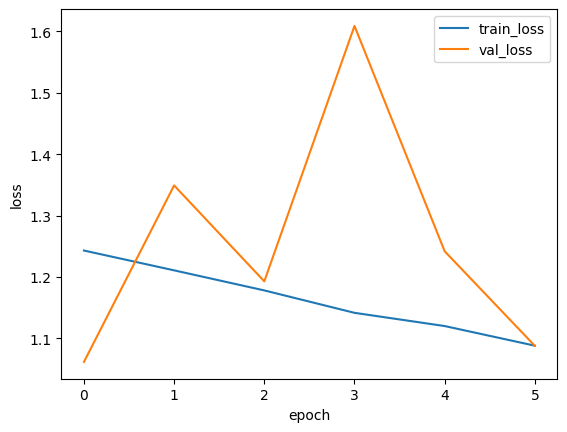

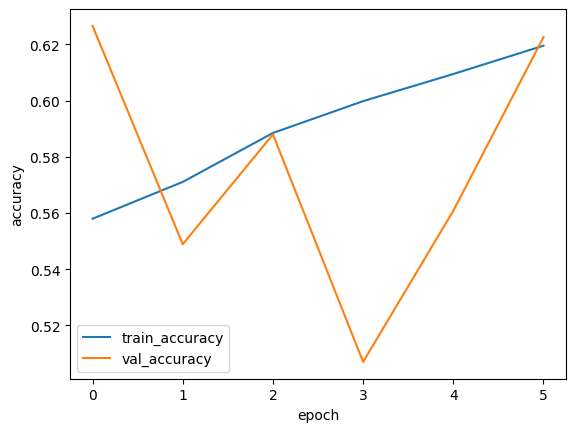

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()